# Zoidberg 2.0


## Introduction

We were given a dataset of x-rays, which took around 20 minutes to install from their server. To speed things up and for convenience we sanitized the dataset and uploaded it to hugging face hub. We will see how fast and concise this solution turned out to be.

Our goal with the dataset is to find the right machine learning model to help doctors in detecting pneumonia. We will proceed by pulling the `train` split of the dataset (as you can see with the `split="train"` parameter).


In [3]:
from datasets import load_dataset

dataset = load_dataset("Az-r-ow/chest_xray", split="train")

In [4]:
from PIL import Image
from io import BytesIO

labels = dataset.features["label"].names


def format_dataset(dataset):
    pd_dataset = dataset.to_pandas()
    pd_dataset["true_label"] = pd_dataset["label"].map(lambda x: labels[x])
    pd_dataset["image"] = pd_dataset["image"].map(
        lambda i: Image.open(BytesIO(i["bytes"]))
    )
    return pd_dataset


# Converting to pandas will encode the images to bytestrings
train_data = format_dataset(dataset)
train_data.head()

,image,label,true_label
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL


Now that we have our data ready, we can start by checking the number of image per `class`.


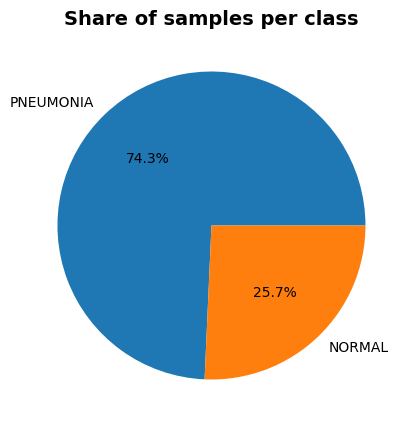

In [5]:
%matplotlib inline

from matplotlib import pyplot as plt

def plot_value_counts(df, col_name, plot_title=""):
  """
  Plot the value counts of a column in a DataFrame.

  Parameters:
  -----------
  df : pandas DataFrame
      The DataFrame containing the column to plot.

  col_name : str
      The name of the column in the DataFrame for which to plot the value counts.

  plot_title : str, optional
      Title of the plot. Default is an empty string.

  Returns:
  --------
  None
  """
  class_counts = df[col_name].value_counts()
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')
  ax.set_title(plot_title, fontsize=14, fontweight="bold")

plot_value_counts(train_data, 'true_label', "Share of samples per class")

We can clearly see an imbalance between the two classes and that's something to keep in mind as it might lead any model towards over-fitting in favor of `infected` (for instances with label `1`).


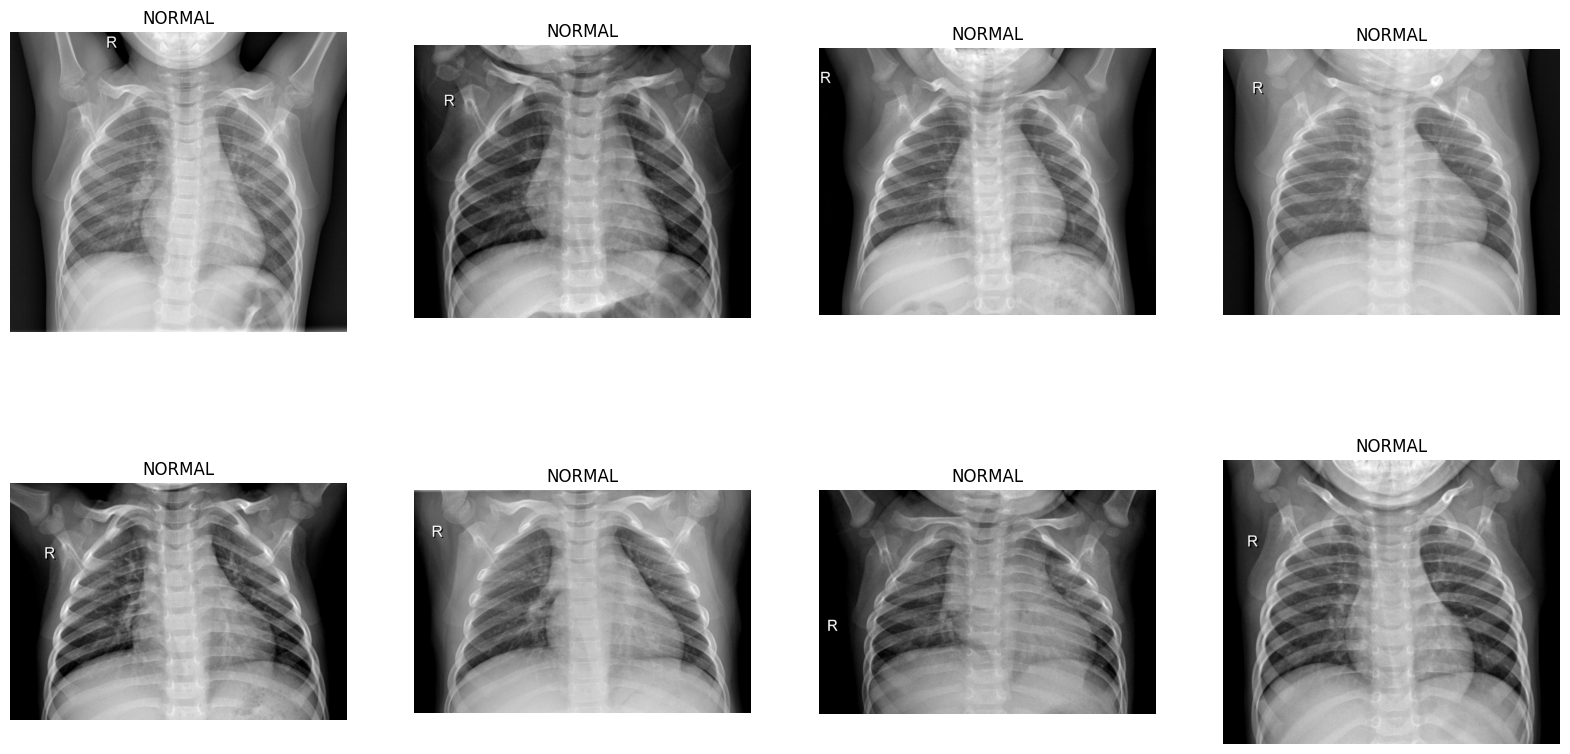

In [6]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import pandas as pd


def get_center_crop_coord(image, target_size=(100, 100)):
    """
    Calculates the coordinates for center cropping an image to the specified target size.

    Parameters:
        image (PIL.Image.Image): The input image to be center cropped.
        target_size (tuple): A tuple specifying the target size (width, height) for the cropped region.

    Returns:
        tuple: A tuple containing the coordinates (x, y, width, height) for center cropping the image.
    """
    width, height = image.size
    crop_x = (width - target_size[0]) // 2
    crop_y = (height - target_size[1]) // 2
    return (crop_x, crop_y, crop_x + target_size[0], crop_y + target_size[1])


# Displaying the images
def display_images(
    data, rows, columns, crop_area=None, scatter_coordinates=([], []), title=""
):
    if len(data) < (rows * columns):
        raise ValueError(
            f"Length data should be > than (rows * columns) we got : {rows * columns} and data length = {len(data)}"
        )

    x_scatter, y_scatter = scatter_coordinates
    is_dataframe = isinstance(data, pd.DataFrame)

    if rows <= 0 or columns <= 0:
        raise ValueError(
            f"Rows and columns can't be <= 0, got : rows = {rows} and columns = {columns}"
        )
    elif rows == 1 and columns == 1:
        fig, ax = plt.subplots()
        image = data[0] if not is_dataframe else data["image"][0]
        title = "" if not is_dataframe else data["true_label"][0]
        ax.imshow(image, cmap="gray")
        ax.set_title(title)
        plt.show()
        return

    fig, axes = plt.subplots(rows, columns, figsize=(20, 10))
    for i, ax in enumerate(axes.flat):
        image = data[i] if not is_dataframe else data["image"][i]
        label = "" if not is_dataframe else data["true_label"][i]
        ax.imshow(image, cmap="gray")
        if i < len(x_scatter) and i < len(y_scatter):
            ax.scatter(x_scatter[i], y_scatter[i])
        ax.set_title(label)

        if crop_area:
            x, y, width, height = crop_area = get_center_crop_coord(image, crop_area)
            rect = patches.Rectangle(
                (x, y),
                crop_area[0],
                crop_area[1],
                linewidth=2,
                edgecolor="r",
                facecolor="none",
            )
            ax.add_patch(rect)

        ax.axis("off")

    plt.show()


display_images(train_data, 2, 4, title="something")

## Class Imbalance

### Problem

As we saw earlier in the pie chart, we have 3 times the number of x-rays of chests with `PNEUMONIA`. That will to a biased model with misleading accuracy. For example if we implement a model that only predicts `1` we will get 74.2% accuracy during training. But that goes AGAINST the goal of **generalization** that we want to achieve.

### Solutions

How can we proceed with this ?

- **Undersampling**
- **Oversampling**
- **Performance Metrics**

Let's go through some more details.

- **Undersampling** we will reduce the training set of $20\%$ which is not a lot considering that the difference between the two classes. This will result in the dataset consisting of $2712$ `PNEUMONIA` rows and $4053$ in total. Performing this operation will reduce the gap between the classes from $49\%$ to $39\%$. But not to worry, it will go down even more with **oversampling**.
- **Oversampling** we will increase the number of `NORMAL` samples by $20\%$ by randomly duplicating rows, the number being reasonable is enough to reduce the gap between the two classes yet not creating a lot of duplication which might corrupt the learning.
  By doing so we'll be able to reduce the gap to $25\%$.

- **Performance Metrics** when the time comes we'll use the metric that either minimizes false positives or false negatives based on the observations.


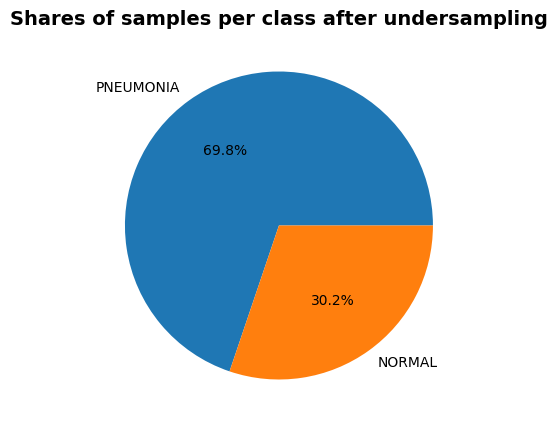

In [7]:
import pandas as pd


def undersample(df, true_label, frac):
    """
    Undersamples a DataFrame by reducing the number of samples for a specific class.

    Parameters:
    -----------
    df : pandas DataFrame
        The DataFrame containing the dataset to be undersampled.

    true_label : str
        The true label of the class for which to perform undersampling.

    rate : float or int
        The desired ratio of samples to retain for the specified class after undersampling.
        If float, it represents the fraction of samples to retain (0.0 to 1.0).
        If int, it represents the absolute number of samples to retain.

    Returns:
    --------
    pandas DataFrame
        The undersampled DataFrame with reduced number of samples for the specified class.

    Example:
    --------
    undersampled_df = undersample(df, 'class', 0.5)
    """
    undersampled_df = pd.concat(
        [
            df[df["true_label"] != true_label],
            df[df["true_label"] == true_label].sample(frac=frac),
        ]
    )
    return undersampled_df.reset_index(drop=True)


train_data = undersample(train_data, "PNEUMONIA", 0.8)  # Retaining 80% of the samples

plot_value_counts(
    train_data, "true_label", "Shares of samples per class after undersampling"
)

Things went as expected the gap between the two classes is not sitting at $39.6\%$ and will be going down even further with oversampling. We want to note that we purposely did not override the `train_data` variable to keep it as a backup in case our results are corrupted and we want to go back to the initial dataset.


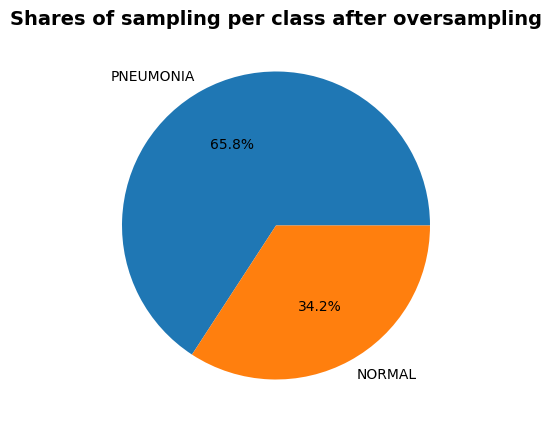

In [8]:
import math


def oversample(df, true_label, frac):
    """
    Oversamples a DataFrame by randomly duplicating the number of samples for a specific class.

    Parameters:
    -----------
    df : pandas DataFrame
        The DataFrame containing the dataset to be oversampled.

    true_label : str
        The true label of the class for which to perform oversampling.

    rate : float or int
        The desired ratio of samples to duplicated from the specified class.
        If float, it represents the fraction of samples to duplicate (0.0 to 1.0).
        If int, it represents duplicating the entirety of the samples.

    Returns:
    --------
    pandas DataFrame
        The oversampled DataFrame with the randomly duplicated number of samples for the specified class.

    Example:
    --------
    oversampled_df = oversample(df, 'class', 0.2)
    """
    majority_class = df[df["true_label"] != true_label]
    minority_class = df[df["true_label"] == true_label]
    frac = 1 + frac if frac < 1 else frac
    num_samples = math.ceil(len(minority_class) * frac)
    oversampled_minority = minority_class.sample(
        num_samples, replace=True, random_state=42
    )
    return pd.concat([majority_class, oversampled_minority]).reset_index(drop=True)


train_data = oversample(train_data, "NORMAL", 0.2)

plot_value_counts(
    train_data, "true_label", "Shares of sampling per class after oversampling"
)

Another win for the team, things are going as planned. The gap between the two classes has been reduced drastically and now with the right **performance metrics** we should be getting some good results.


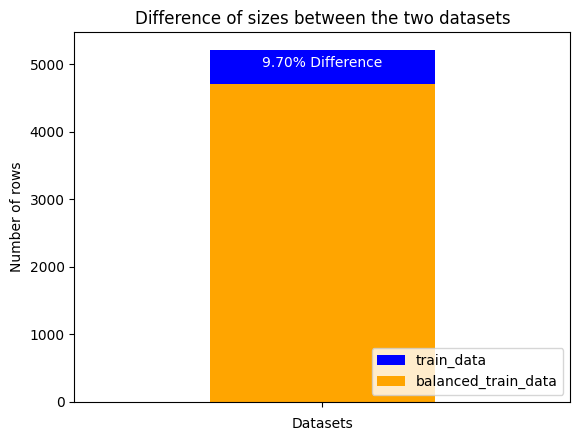

In [9]:
%matplotlib inline 

initial_data_num_rows = len(dataset)
balanced_train_data_num_rows = len(train_data)
avg = (initial_data_num_rows + balanced_train_data_num_rows) / 2
fig, ax = plt.subplots()

ax.bar(
    [""],
    [initial_data_num_rows, balanced_train_data_num_rows],
    width=0.4,
    label=["train_data", "balanced_train_data"],
    color=["blue", "orange"],
)
ax.bar([""], [0])
ax.text(
    0,
    avg,
    f"{((1 - (balanced_train_data_num_rows / initial_data_num_rows)) * 100):.2f}% Difference",
    ha="center",
    color="white",
)
ax.set_title("Difference of sizes between the two datasets")
ax.legend(loc="lower right")
plt.xlabel("Datasets")
plt.ylabel("Number of rows")
plt.show()

We were able to reduce the gap between the two classes from $49\%$ to $30\%$ by only decreasing the total number of samples by less than $10\%$ which is great. Considering that we have large dataset, this slight decrease shouldn't have any negative effect.

Now that our data is ready, we will start the training process.


## Observation

Let's first take a look at the images of the two classes side by side. We will be looking for similarities from within the different classes. We'll take `4` images from each class and display them.


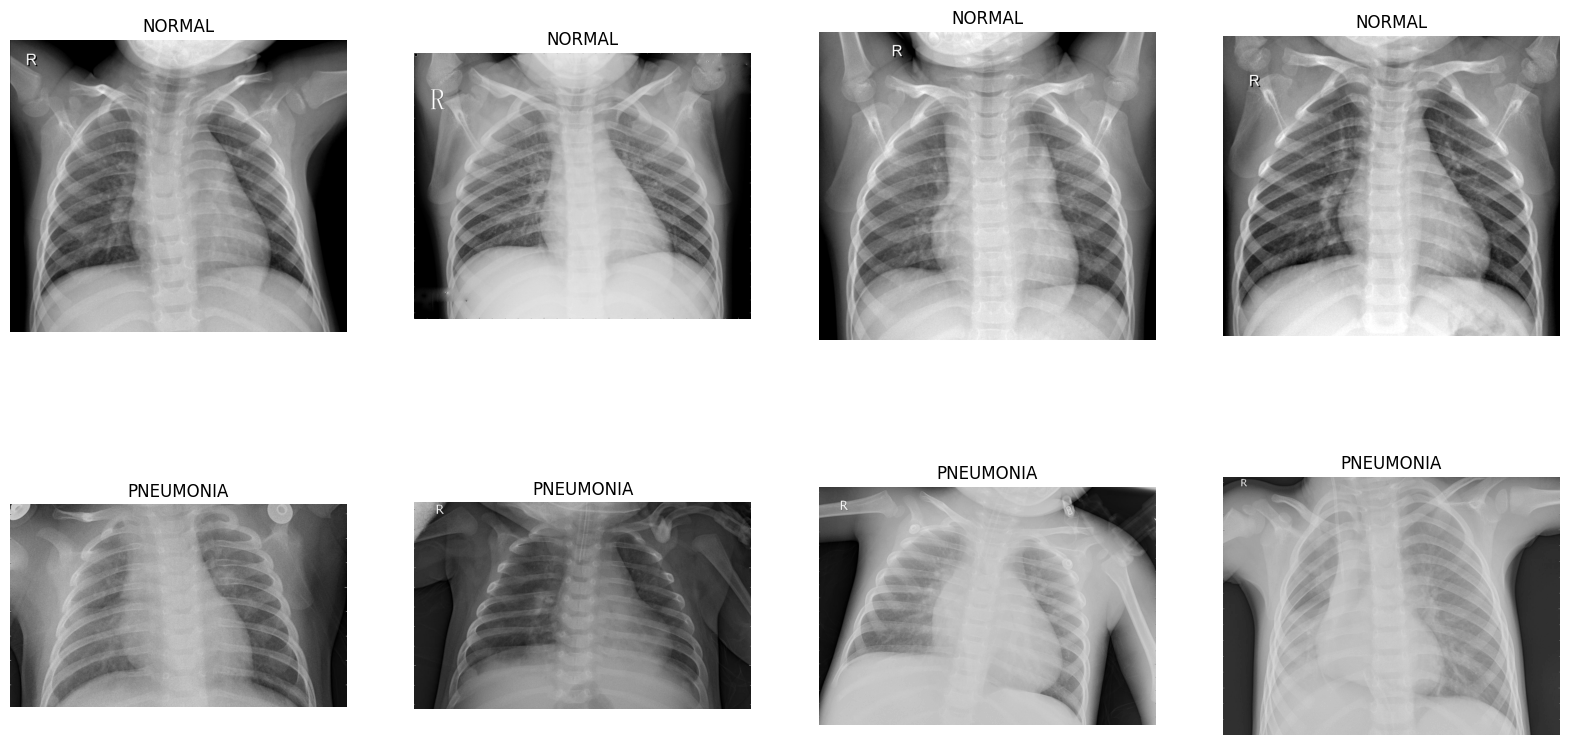

In [10]:
normal_images_sample = (
    train_data[train_data["true_label"] == "NORMAL"].head(4).reset_index(drop=True)
)
pneumonia_images_sample = (
    train_data[train_data["true_label"] == "PNEUMONIA"].head(4).reset_index(drop=True)
)
images_samples = pd.concat([normal_images_sample, pneumonia_images_sample]).reset_index(
    drop=True
)

display_images(images_samples, 2, 4)

## Data Processing

In some cases we can see a pattern between the images in each class. It seems like the x-rays with pneumonia have a larger density of white matter in the lungs which is in most cases located in the middle of the images. But it's not always very clear. However, one thing is sure : to reduce the noise in our dataset we should center crop the images in order to have the principal area of interest. Here's the following steps that we'll go over :

1. Center crop the images to remove the outside noise and regularize the images
2. Make sure the images are centered before moving on to `PCA`
3. Apply `PCA` (Principal Component Analysis) and plot the values of `PCA-1`, `PCA-2` and then `PCA-3`


In [11]:
import numpy as np


def preprocess_image(img, resize_size=(512, 512), target_size=(400, 400)):
    """
    Preprocesses an image by resizing and center cropping it to the target size. The image is also transformed to grayscale.

    Parameters:
        img (PIL.Image.Image): The input image to be preprocessed.
        resize_size (tuple): A tuple specifying the resize size (width, height) for the preprocessed image.
        target_size (tuple): A tuple specifying the target size (width, height) for the preprocessed image.

    Returns:
        PIL.Image.Image: The preprocessed image resized to the `target_size`.

    Note:
    - The `target_size` should be < than the `resize_size`
    """
    if target_size > resize_size:
        raise ValueError(
            f"target_size can't be > than resize_size. Got target_size = {target_size} and resize_size = {resize_size}"
        )
    grayscale_image = img.convert("L")
    resized_image = grayscale_image.resize(resize_size)

    crop_coord = get_center_crop_coord(resized_image, target_size)

    cropped_image = resized_image.crop(crop_coord)
    return cropped_image

The following block demonstrates taking a horizontal image, resizing it to `(80, 80)` pixels, then center cropping it to a `(50, 50)` image. The purpose of it is to give a visual on how the images will be processed in the following steps.

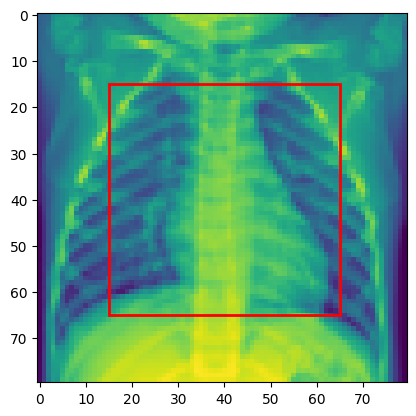

In [12]:
import matplotlib.patches as patches

demo_image = normal_images_sample["image"][3]

grayscale = demo_image.convert("L")

resized_image = grayscale.resize((80, 80))

crop_size = (50, 50)

crop_coord = get_center_crop_coord(resized_image, crop_size)

c_width, c_height = crop_size
x1, y1, x2, y2 = crop_coord

rect = patches.Rectangle((x1, y1) ,c_width, c_height, linewidth=2, edgecolor='r', facecolor='none')

fig, ax = plt.subplots()

ax.imshow(resized_image)
ax.add_patch(rect)

plt.show()

In [13]:
x_train = (
    train_data["image"]
    .map(lambda x: preprocess_image(x, (80, 80), (50, 50)))
    .reset_index(drop=True)
)

# transforming the pillow images and saving them for later use
np.save("./datasets/x_train.npy", [np.array(img) for img in x_train])

In [14]:
y_train = train_data["label"].reset_index(drop=True).to_numpy()
np.save("./datasets/y_train.npy", y_train)

In the previous code, we format the image and center crop them to narrow down to the essential parts of the scans which are the lungs. We'll demonstrate what the resulting images will look like after processing.


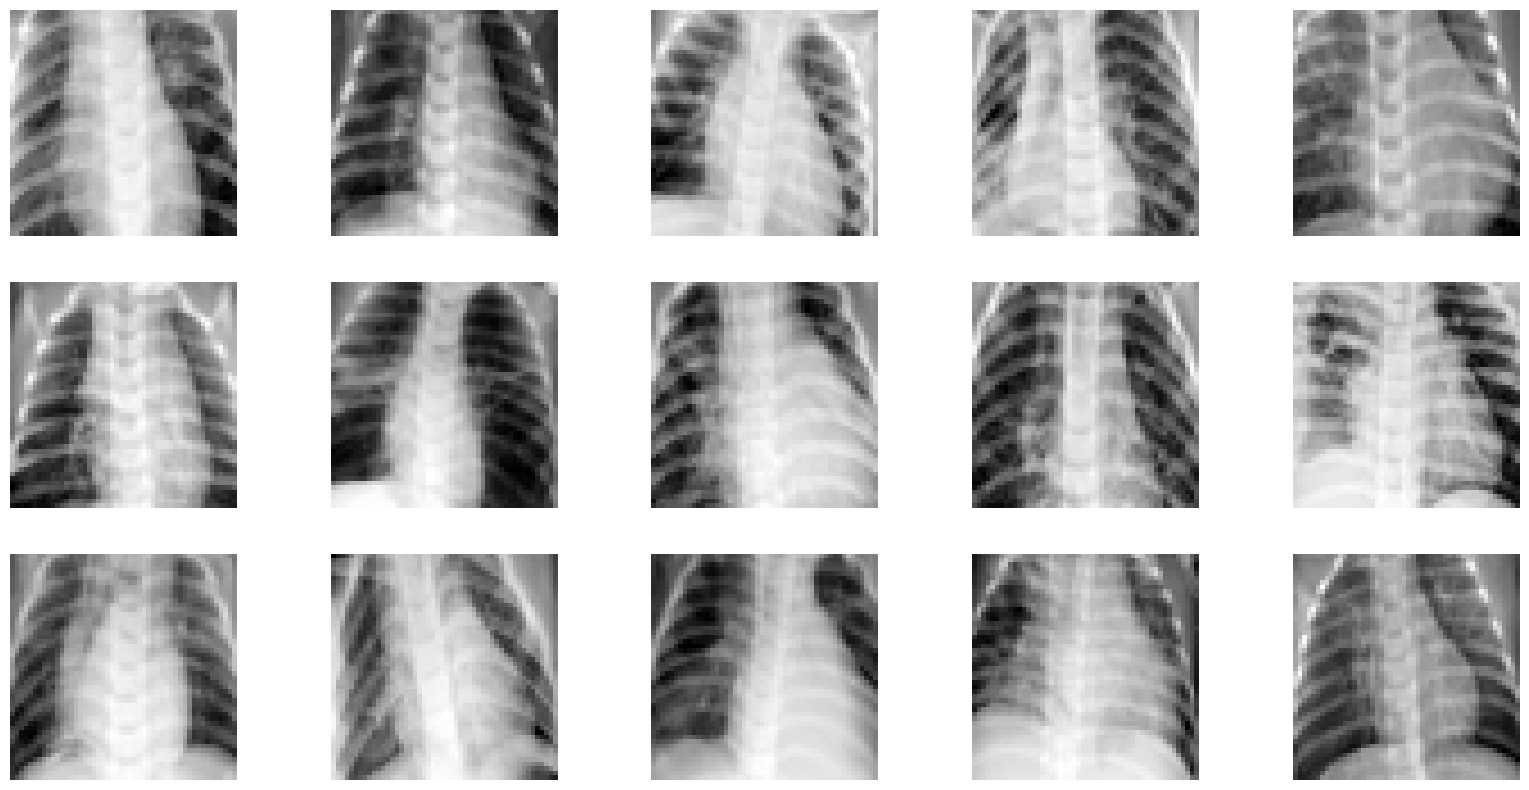

In [15]:
%matplotlib inline
display_images(x_train, 3, 5)

Then we will calculate the `center_of_mass` of each picture, this method basically averages the position of all the pixels of the image, weighted by their intensity values. The purpose of doing so, is to make sure the spine is somewhat centered in the cropped images.


/Users/az-r-ow/epitech/msc/zoidberg/venv/lib/python3.10/site-packages/scipy/ndimage/_measurements.py:1542: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


mean offset :  3.0946921443736732
std offset :  2.8857865060894747


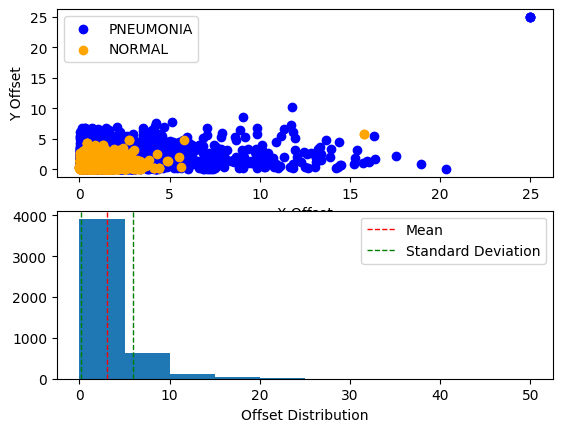

In [16]:
%matplotlib inline
from scipy.ndimage import center_of_mass


def get_center_of_mass(image):
    """
    Calculate the center of mass of a binary image.

    This function takes a binary image as input, where foreground pixels are represented as True (or 1)
    and background pixels are represented as False (or 0). It then computes the center of mass (COM)
    of the binary image, which represents the average position of all the foreground pixels.

    Parameters:
    - image: numpy.ndarray
        The input binary image represented as a NumPy array.

    Returns:
    - center: tuple
        A tuple containing the coordinates (row, column) of the center of mass of the binary image.
        The row and column indices start from 0.

    Note:
    - The input image should be a binary image where foreground pixels are represented by True (or 1) and
      background pixels are represented by False (or 0).
    - The center of mass is computed using the center_of_mass function from the scipy.ndimage module.
      Make sure to import this function before using get_center_of_mass.
    """
    binary_image = np.array(image) > 128
    com = center_of_mass(binary_image)
    return (0, 0) if  np.isnan(com).any() else com


def calculate_offset(image):
    """
    Calculate the offset between the center of mass (COM) and the geometric center of a binary image.

    Parameters:
    - image: numpy.ndarray
        The input binary image represented as a NumPy array.

    Returns:
    - offset: numpy.ndarray
        A NumPy array representing the offset between the center of mass and the geometric center.
        The offset is computed as the center of mass (COM) minus the geometric center.
        The offset has the same dimensionality as the input image.

    Note:
    - The geometric center is computed as the center of the image grid, which is assumed to be at the
      half width and half height of the image.
    - The offset indicates the displacement of the center of mass relative to the geometric center.
    """

    com = get_center_of_mass(image)
    
    image = np.array(image)

    geometric_center = np.array(image.shape) / 2
    
    # print(geometric_center)

    offset = com - geometric_center
    
    # Check for NaN in the tuple
    if any(math.isnan(x) for x in offset):
        raise Exception("nan found")
    
    return np.abs(offset)


offsets = [calculate_offset(img) for img in x_train]
x_offsets = np.array([offset[0] for offset in offsets])
y_offsets = np.array([offset[1] for offset in offsets])
# To not end up with fraction of pixels
offsets_distribution = np.round(x_offsets + y_offsets)
mean = np.mean(offsets_distribution)
std = np.std(offsets_distribution)

print("mean offset : ", mean)
print("std offset : ", std)

fig, axs = plt.subplots(2)

normal_indices = [i for i, c in enumerate(y_train) if labels[c] == "NORMAL"]
pneum_indices = [i for i, c in enumerate(y_train) if labels[c] == "PNEUMONIA"]

axs[0].scatter(
    x_offsets[pneum_indices], y_offsets[pneum_indices], c="blue", label="PNEUMONIA"
)
axs[0].scatter(
    x_offsets[normal_indices], y_offsets[normal_indices], c="orange", label="NORMAL"
)
axs[0].set_xlabel("X Offset")
axs[0].set_ylabel("Y Offset")
axs[0].legend()

axs[1].hist(offsets_distribution)
axs[1].axvline(mean, color="r", linestyle="dashed", linewidth=1, label="Mean")
axs[1].axvline(
    mean - std, color="g", linestyle="--", linewidth=1, label="Standard Deviation"
)
axs[1].axvline(mean + std, color="g", linestyle="--", linewidth=1)
axs[1].set_xlabel("Offset Distribution")
axs[1].legend()

plt.show()

We notice that the vast majority of the images are centered with an average offset of `4.7` pixels. However, very few images have some important offset. Does that mean that these images are not centered ? Let's see what it means...


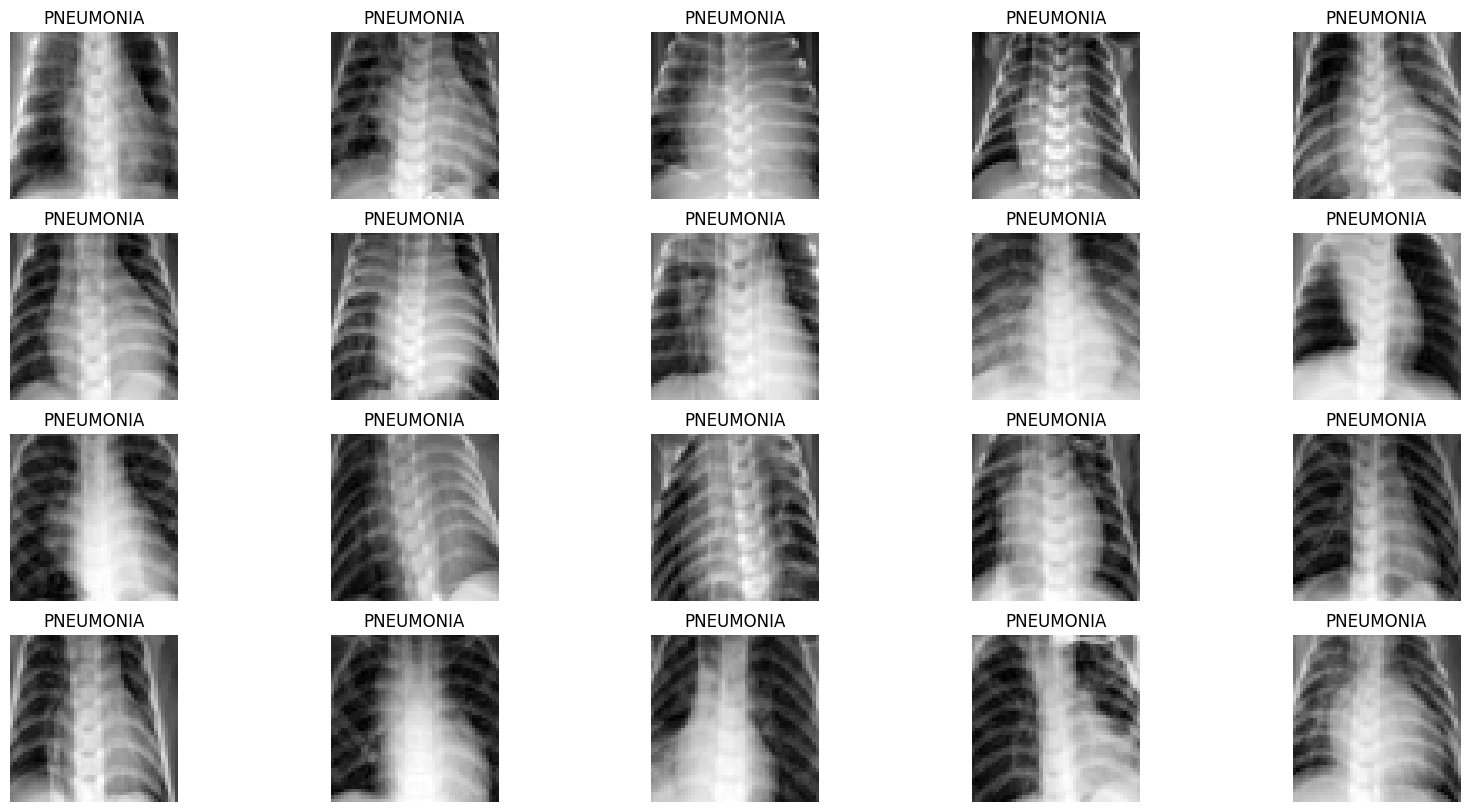

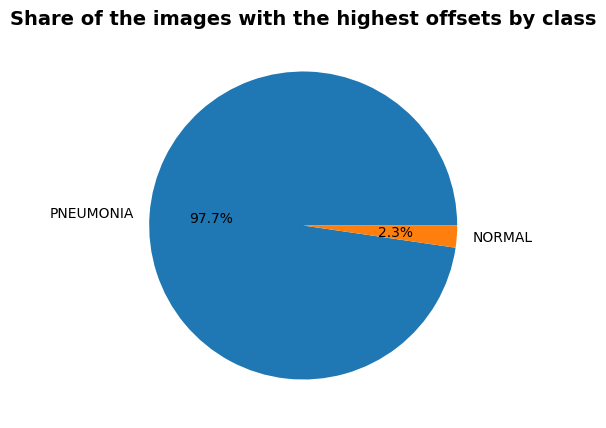

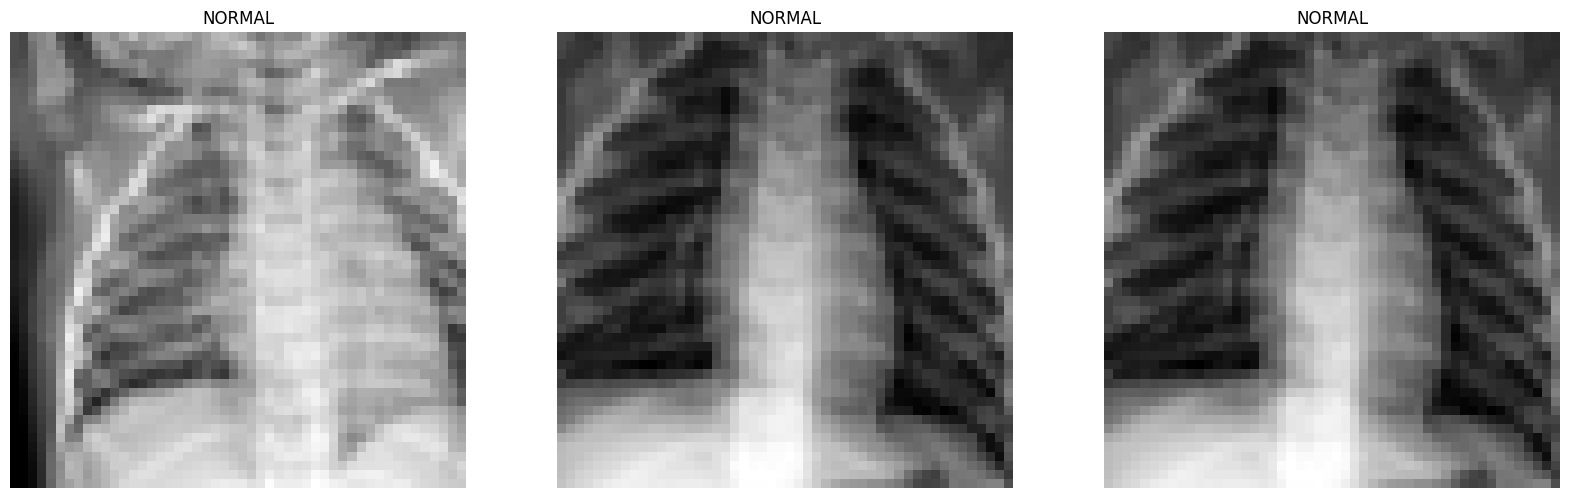

In [17]:
%matplotlib inline
high_offset_images = {"image": [], "true_label": [], "x_com": [], "y_com": []}

for i, offset in enumerate(offsets):
    if np.sum(offset) > 10:
        high_offset_images["image"].append(x_train[i])
        high_offset_images["true_label"].append(labels[y_train[i]])
        x_com, y_com = get_center_of_mass(x_train[i])
        high_offset_images["x_com"].append([x_com])
        high_offset_images["y_com"].append([y_com])

high_offset_images = pd.DataFrame(high_offset_images)
x_com = high_offset_images["x_com"].to_list()
y_com = high_offset_images["y_com"].to_list()

display_images(high_offset_images, 4, 5)

plot_value_counts(
    high_offset_images,
    "true_label",
    "Share of the images with the highest offsets by class",
)

# Filter normal images that have a high offset
normal_high_offset_images = high_offset_images[high_offset_images["true_label"] == "NORMAL"].reset_index(drop=True)
num_normal_images = len(normal_high_offset_images)

if num_normal_images:
    cols = num_normal_images if num_normal_images < 5 else 5
    rows = min(math.floor(num_normal_images / cols), 3)
    display_images(normal_high_offset_images, rows, cols)
    

In the previous code blocks, we extract the samples with the **highest** offset from the geometric center of image. We can conclude from the previous chart, that the images are well centered and the few exceptions we got are linked to a white blob located at a certain distance from the geometric center therefore pulling the `center_of_mass` towards it. Hence the exceptionally big `offsets`.

Now that we know that our images are well centered, we can proceed with finding the right model for **classification**.


In [18]:
from PIL import ImageDraw


def apply_black_border(image, border_width):
    """
    Apply a black border around the edges of the image.

    Parameters:
    - image: PIL.Image.Image
        The input image.
    - border_width: int
        The width of the black border to apply around the edges of the image.

    Returns:
    - bordered_image: PIL.Image.Image
        The image with a black border applied around the edges.
    """
    # Copy the original image
    bordered_image = image.copy()

    # Get the dimensions of the input image
    width, height = image.size

    # Create a black border mask
    mask = Image.new("L", (width, height), 0)
    draw = ImageDraw.Draw(mask)
    draw.rectangle((0, 0, width, border_width), fill=255)  # Top border
    draw.rectangle((0, height - border_width, width, height), fill=255)  # Bottom border
    draw.rectangle((0, 0, border_width, height), fill=255)  # Left border
    draw.rectangle((width - border_width, 0, width, height), fill=255)  # Right border

    # Paste the black border mask onto the image
    bordered_image.paste(0, (0, 0), mask)

    return bordered_image

## Dimension Reduction

We will first do a **Principal Component Analysis** (`PCA`) to reduce the dimensionality of the images, and then we will plot the first two `PCA`s and then the third in a 3-D plot.

> **NOTE:** This might take a few minutes depending on your hardware, but it's totally worth it


> **NOTE 2:** To cut on wait times set `n_components` to `0.8` it will keep $80\%$ of the dataset's information.


> **NOTE 3:** We will demonstrate why `0.8` [here](#comparing-classification-results-with-different-n_components)


> **NOTE 4:** If you already have the resulting numpy array stored in a file you can skip this step and the following analysis and move to [model discovery](#model-discovery)


In [19]:
from sklearn.decomposition import PCA


def normalize_images(images):
    return np.array([np.asarray(img).ravel() / 255.0 for img in images])


# normalizing the images into row vectors
x_train = normalize_images(x_train)

In [20]:
pca = PCA()

x_train_pca = pca.fit_transform(x_train)

Let's take a look at the **explained variance ratio** of each component for the first `10` components.


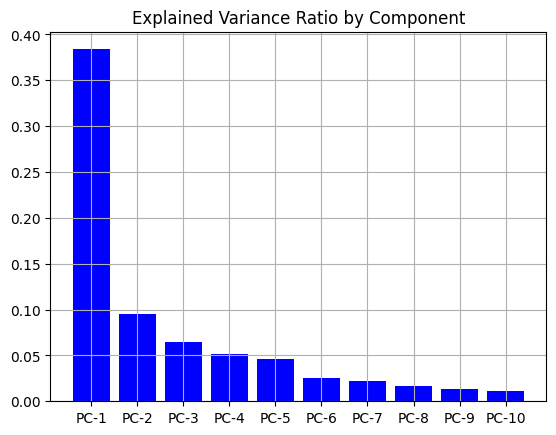

In [21]:
%matplotlib inline 

explained_variance_ratio_10 = pca.explained_variance_ratio_[:10]
pc_10 = [f"PC-{i}" for i in range(1, len(explained_variance_ratio_10) + 1)]

plt.bar(pc_10, explained_variance_ratio_10, color="blue")
plt.title("Explained Variance Ratio by Component")
plt.grid(True)
plt.show()

We can see that the first two **principal components** account for more than $40\%$ of the explained variance of the entire dataset. In other words, only **TWO** components account for more than $40\%$ of the dataset's information.


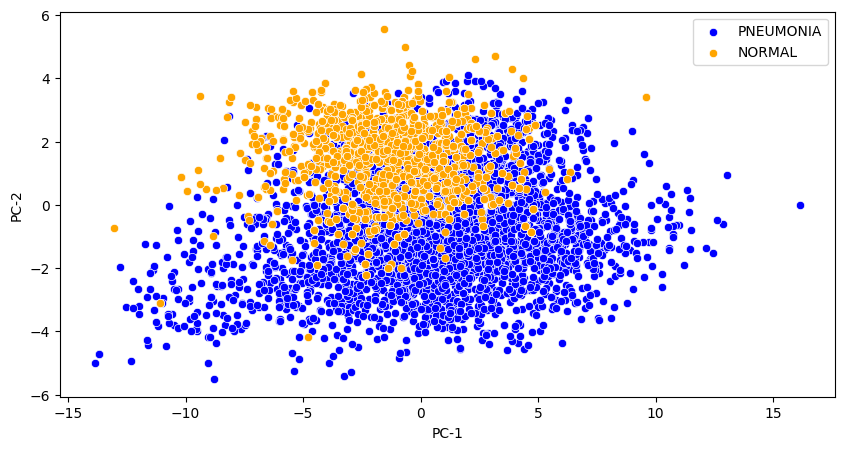

In [22]:
%matplotlib inline
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.scatterplot(x=x_train_pca[pneum_indices, 0], y=x_train_pca[pneum_indices, 1], color="blue", label="PNEUMONIA")
sns.scatterplot(x=x_train_pca[normal_indices, 0], y=x_train_pca[normal_indices, 1], color="orange", label="NORMAL")
plt.xlabel("PC-1"), plt.ylabel("PC-2")
plt.show()

Observations from `PCA` on `PC-1` and `PC-2` :

- `NORMAL` data points tend to vary between -50 and 50 on `PC-1` and has mainly high values on `PC-2`
- `PNEUMONIA` data points in the other hand vary on a much wider range on both `PC-1` and `PC-2`
- Even though `NORMAL` instances seem to have more correlation between them, this can't be said for `PNEUMONIA` instances that are relatively more scattered along both axes.


Therefore, no definitive conclusion can be drawn from the previous plot. We will move on to plotting the first **three principal components** on a 3 dimensional space.


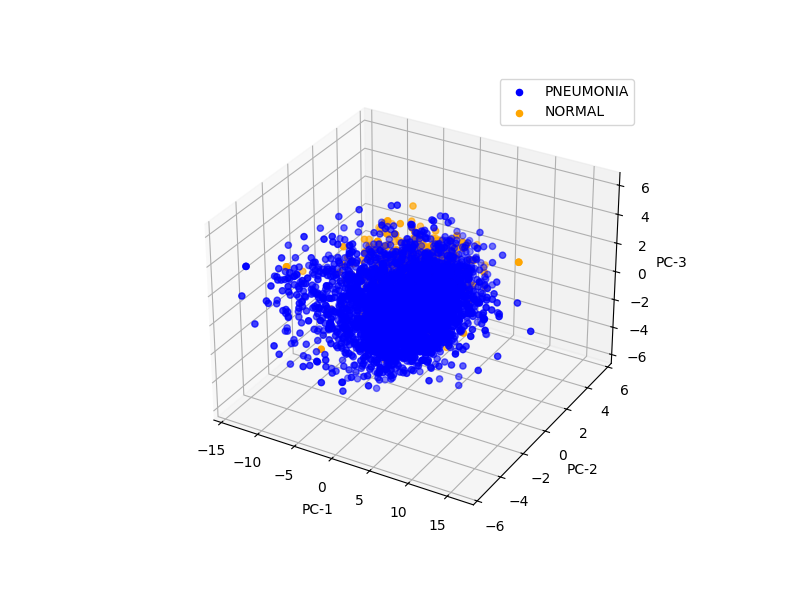

In [23]:
%matplotlib widget

# Assuming X_3d is your 3D data array and labels is your corresponding labels array
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    x_train_pca[pneum_indices, 0],
    x_train_pca[pneum_indices, 1],
    x_train_pca[pneum_indices, 2],
    color="blue",
    label="PNEUMONIA"
)

ax.scatter(
    x_train_pca[normal_indices, 0],
    x_train_pca[normal_indices, 1],
    x_train_pca[normal_indices, 2],
    color="orange",
    label="NORMAL"
)

ax.set_xlabel('PC-1')
ax.set_ylabel('PC-2')
ax.set_zlabel('PC-3')

plt.legend()
plt.show()

Even though a clear separation is not present, adding the third **principal component** did help us in getting extra underlying structure in the data.


Now before passing the reduce data to a model, let's see how many **components** account for `[.8, .9, .95, .99]` of the variance of the entire dataset. Visualizing it would help us make the decision of choosing the right number of components to proceed with without losing a lot of information.


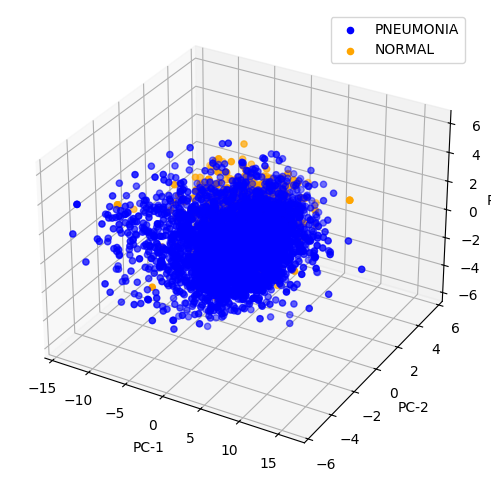

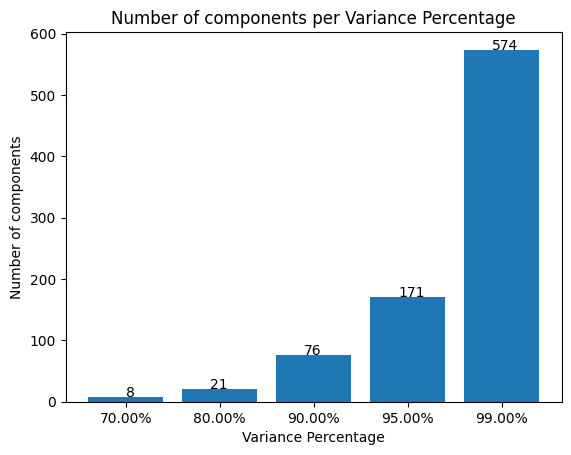

No such comm: 250b336f7c104dc5a080d62c54461acd
No such comm: 250b336f7c104dc5a080d62c54461acd
No such comm: 250b336f7c104dc5a080d62c54461acd
No such comm: 250b336f7c104dc5a080d62c54461acd
No such comm: 250b336f7c104dc5a080d62c54461acd
No such comm: 250b336f7c104dc5a080d62c54461acd


In [24]:
%matplotlib inline

def components_for_variance_percentage(variance_ratios, per=0.99):
    """
    Calculate the number of components required to achieve a given percentage of variance.

    Parameters:
    - variance_ratios (array-like): Array containing the explained variance ratios for each component.
    - per (float): Desired percentage of variance to be explained, in the range [0, 1].

    Returns:
    - int: Number of components needed to explain the specified percentage of variance.
    """
    cumulative_variance = np.cumsum(variance_ratios)
    return np.argmax(cumulative_variance >= per) + 1


percentages = [0.7, 0.8, 0.9, 0.95, 0.99]
num_components = [
    components_for_variance_percentage(pca.explained_variance_ratio_, per)
    for per in percentages
]

fig, ax = plt.subplots()
bars = ax.bar(["{:.2%}".format(value) for value in percentages], num_components)
for bar in bars:
    yval = bar.get_height()
    ax.text(
        (bar.get_x() + (bar.get_width() / 2) - (math.floor(len(str(yval)) / 2) / 10)),
        yval + 0.005,
        yval,
    )

ax.set_title("Number of components per Variance Percentage")
ax.set_xlabel("Variance Percentage")
ax.set_ylabel("Number of components")
plt.show()

Initially, we had images of size `(50,50)` that's $2500$ parameter per image. After dimension reduction, we're able to retain $99\%$ of the information with only $576$ components. We will experiment using each of these number of components with a **Support Vector Machine** (`SVM`) to get a comparison on how much they affect the score.


We'll start by keeping only the number of components that represents $99\%$ by and dropping the rest.


In [25]:
per_to_ncomponents = {
    percentages[i]: num_components[i] for i in range(len(num_components))
}

In [26]:
x_train_pca = x_train_pca[:, : per_to_ncomponents[0.99]]

We will also need to apply dimension reduction to `x_test`.


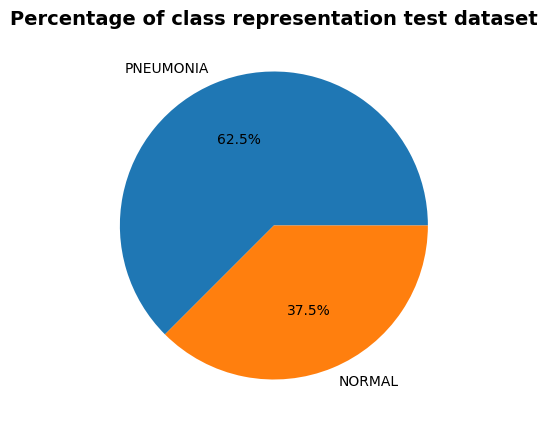

In [27]:
# Fetching the test data from hugging face
test_dataset = load_dataset("Az-r-ow/chest_xray", split="test")
test_dataset = format_dataset(test_dataset)

plot_value_counts(
    test_dataset, "true_label", "Percentage of class representation test dataset"
)

# Formatting the images
x_test = (
    test_dataset["image"]
    .map(lambda x: preprocess_image(x, (80, 80), (50, 50)))
    .reset_index(drop=True)
    .to_numpy()
)
# transforming the unnormalized images to numpy arrays for later use
np.save("./datasets/x_test.npy", [np.array(img) for img in x_test])

In [28]:
# Transforming the images to vectors with values between [0, 1]
x_test = normalize_images(x_test)

y_test = test_dataset["label"].to_numpy()

np.save("./datasets/y_test.npy", y_test)

# Reduce dimensions of the test data
x_test_pca = pca.transform(x_test)

### Comparing classification results with different n_components


Now that we have our training and testing set are ready, we can move on with **Support Vector Classification** which is an `SVM` for classification. We will use it with `kernel="rbf"` because it work best with complex decision boundaries between classes. Also, we will not tune any hyperparameters yet because our goal is to compare the scores between the data with the different `n_components`.


In [29]:
%matplotlib inline

from sklearn.svm import SVC 
from sklearn.metrics import confusion_matrix

scores = []
confusion_matrices = []

for percentage, n_components in per_to_ncomponents.items():
  svc = SVC(kernel="rbf")
  svc.fit(x_train_pca[:, :n_components], y_train)
  y_pred = svc.predict(x_test_pca[:, :n_components])
  cm = confusion_matrix(y_test, y_pred)
  confusion_matrices.append(cm)
  score = svc.score(x_test_pca[:, :n_components], y_test)
  scores.append(round(score, 3))

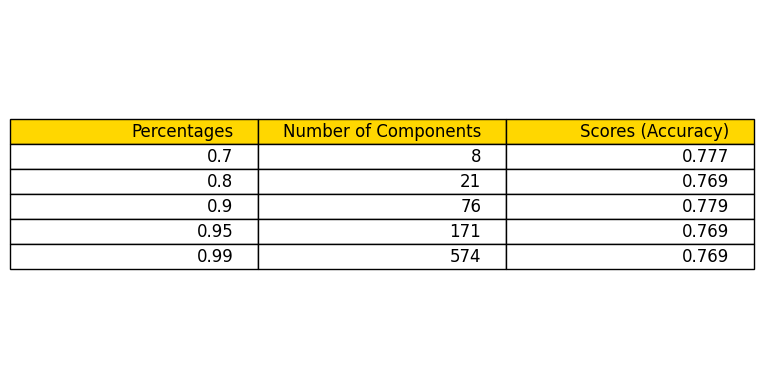

In [30]:
svc_scores_data = [
    [a, b, c]
    for a, b, c in zip(
        list(per_to_ncomponents.keys()), list(per_to_ncomponents.values()), scores
    )
]
svc_scores_data.insert(0, ["Percentages", "Number of Components", "Scores (Accuracy)"])

fig, ax = plt.subplots()
table = ax.table(cellText=svc_scores_data, loc="center")
table.set_fontsize(12)
table.scale(1.5, 1.5)

for i in range(len(svc_scores_data[0])):
    table[(0, i)].set_facecolor("#FFD700")
ax.axis("off")
plt.show()

Here's what the confusion matrix for each looks like :


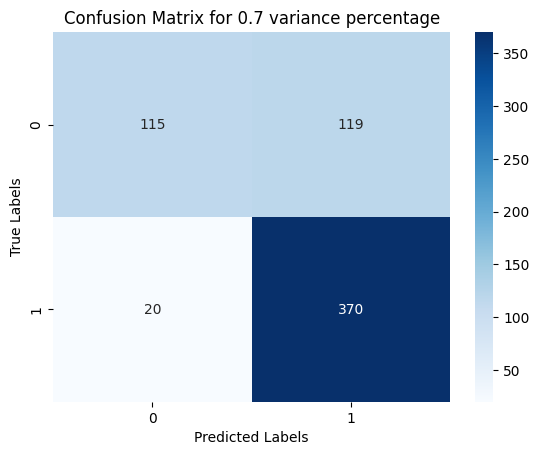

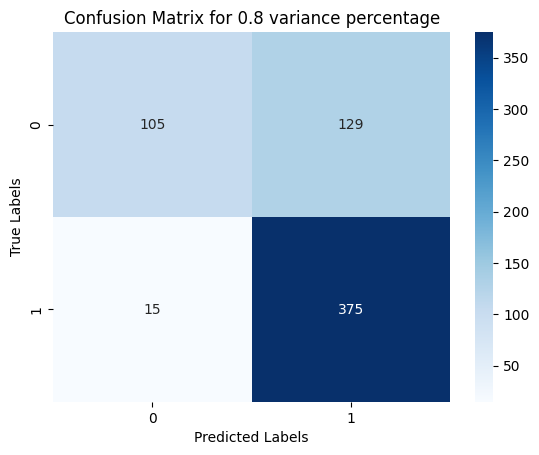

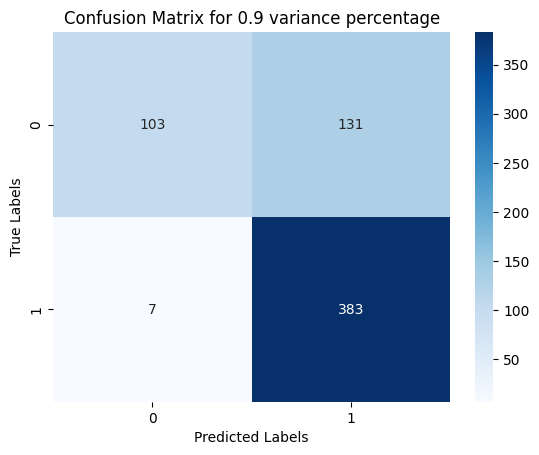

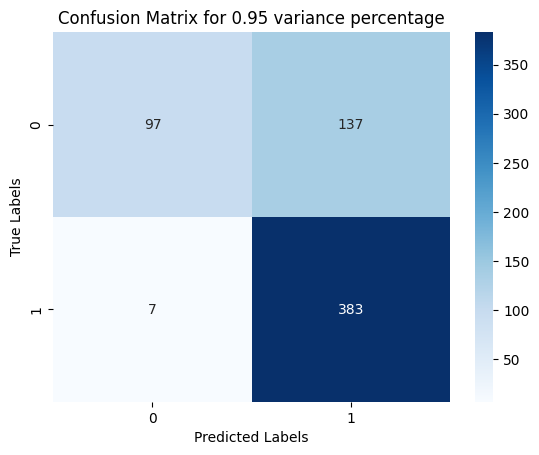

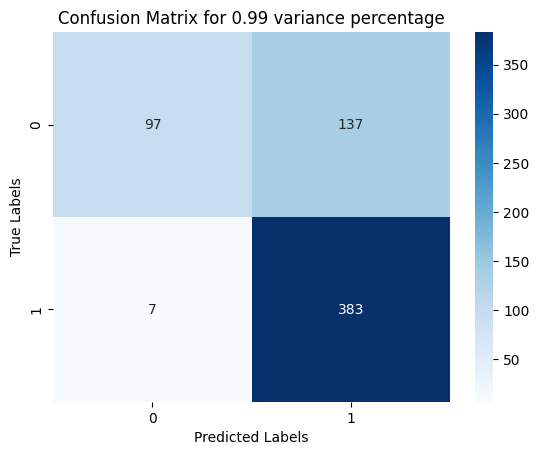

In [31]:
for i, cm in enumerate(confusion_matrices):
    plt.figure(i)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(
        f"Confusion Matrix for {list(per_to_ncomponents.keys())[i]} variance percentage"
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

#### Conclusion on n_components

There is little to no difference in the accuracy scores between the different number of components. If anything, `n_components` representing $80\%$ of the dataset's variance is performing slightly better than the rest (which can be established through the confusion matrices). That's because it's the sweet spot between having too much noise and too little information. Therefore, we can move on by only using only the number of components that represent $80\%$ of the dataset's **variance**.


In [32]:
x_train_pca = x_train_pca[:, : per_to_ncomponents[0.8]]
x_test_pca = x_test_pca[:, : per_to_ncomponents[0.8]]

In [33]:
# Saving models for easy retrieval
np.save("./datasets/x_train_pca.npy", x_train_pca)
np.save("./datasets/x_test_pca.npy", x_test_pca)

## Model Discovery

We will use `RandomizedSearchCV` with the `roc-auc` scoring to be able to test a wide array of hyperparameters the most efficient way possible. The reason why we use `roc-auc` scoring is that we have class imbalance and accuracy only captures the correct guesses. So if we have a **dummy** model that only guesses the majority class, we will have a score of $\approx63\%$ pretty _decent_ right ? So instead, `roc-auc` calculates the **area under the Receiver Operating Characteristic** curve which basically plots the **true positive rate** (TPR) against the **false positive rate** (FPR) for different threshold values. In other terms it evaluates the ability for a model to differentiate between positive and negative instances across threshold values. We will see an example of how it works for `SVC` and for the rest we'll just use the score.


In addition, for each model, after extracting the best parameters we will `train` and `evaluate` them with the found parameters using **Cross Validation** (with `StratifiedKFold` to preserve percentage of samples of each class) whilst keeping track of `["f1", "accuracy", "roc_auc"]` scores for maximum generalization.


In [34]:
import numpy as np

y_train = np.load("./datasets/y_train.npy")
x_train_pca = np.load("./datasets/x_train_pca.npy")
y_test = np.load("./datasets/y_test.npy")
x_test_pca = np.load("./datasets/x_test_pca.npy")

### SVC

Starting with `SVC` (since it was used earlier), we will test the model with different `C`s and `kernels=['rbf', 'poly', 'sigmoid']`s. We will not waste any time with **linear** because we know for a fact (from the previous charts) that our data is not **linearly separable**.


In [35]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


def randomized_search_cv(estimator, param_distributions: dict):
    rand_search_cv = RandomizedSearchCV(
        estimator, param_distributions, scoring="roc_auc", cv=cv, random_state=42
    )
    rand_search_cv_results = rand_search_cv.fit(x_train_pca, y_train)
    return rand_search_cv_results

In [36]:
svc = SVC()

param_distributions = {
    "C": [0.1, 1, 10, 100, 1000],
    "kernel": ["rbf", "poly", "sigmoid"],
    "degree": list(range(1, 11)),  # Just for "poly"
}

svc_search = randomized_search_cv(svc, param_distributions)
svc_search.best_params_

{'kernel': 'rbf', 'degree': 7, 'C': 10}

In [37]:
import re


def plot_cv_results(cv_results_, title=""):
    df = pd.DataFrame(cv_results_)
    df = df.sort_values(by="rank_test_score")

    pattern = re.compile(r"split[0-9]+_test_score")

    split_columns = [c for c in df.columns.values.tolist() if pattern.match(c)]

    # Picking only the columns to plot
    df = df[["params"] + split_columns]
    df["params"] = df["params"].astype(str)

    # Rotating the dataframe
    df = df.melt(id_vars="params", value_vars=split_columns)

    plt.figure(figsize=(10, 6))
    sns.boxplot(df, x="value", y="params", fliersize=0)
    plt.xlabel("ROC_AUC Score")
    plt.title(title)
    plt.show()

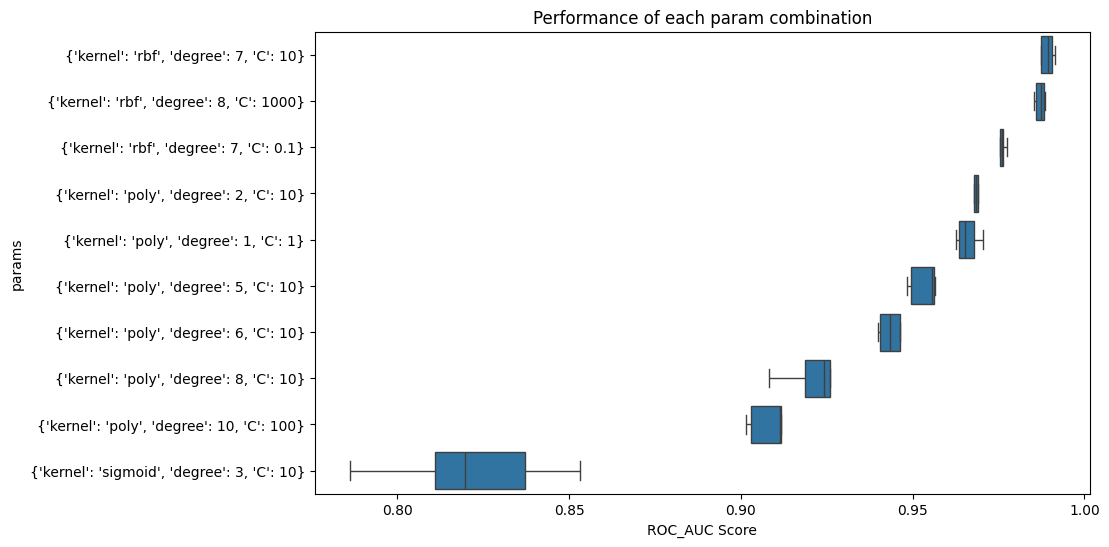

In [38]:
%matplotlib inline
plot_cv_results(svc_search.cv_results_, "Performance of each param combination")

It seems like a `kernel="rbf"` with a `C=10` is the winner with an average `f1` score of : `0.96`. Let's train a model with these parameters and evaluate it.


In [39]:
from sklearn.model_selection import cross_validate

model_scores = {}
scoring = ["f1", "accuracy", "roc_auc"]


def save_model_scores(cv_results: dict, estimator_name: str):
    model_scores[estimator_name] = {
        score: cv_results[f"test_{score}"] for score in scoring
    }
    return model_scores


def evaluate_model(estimator, estimator_name: str):
    res_cv = cross_validate(estimator, x_train_pca, y_train, scoring=scoring, cv=cv)
    save_model_scores(res_cv, estimator_name)
    return

We will keep track of the model scores in the `model_scores` variable. And we will also check it's **ROC_AUC** curve.


In [40]:
# Each model with the top parameters will be assigned the t_ prefix (for top)
t_svc = SVC(C=10, kernel="rbf")
evaluate_model(t_svc, "svc")

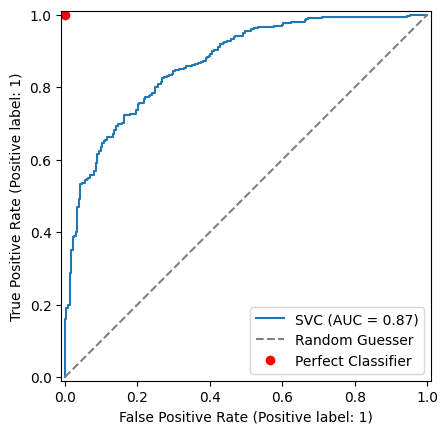

In [41]:
from sklearn.metrics import RocCurveDisplay

t_svc = t_svc.fit(x_train_pca, y_train)
RocCurveDisplay.from_estimator(t_svc, x_test_pca, y_test)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guesser")
plt.plot(0, 1, "ro", label="Perfect Classifier")
plt.legend()
plt.show()

### Random Forest

Now that we have **fine-tuned** and **evaluated** the `SVC` model, we can move on to `RandomForestClassifier`.


In [42]:
from sklearn.ensemble import RandomForestClassifier

param_distributions = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 100, 1000, None],
    "max_features": ["sqrt", "log2", 0.5],
    "min_samples_leaf": [1, 2, 5, 10],
}

rfc = RandomForestClassifier()

rfc_search = randomized_search_cv(rfc, param_distributions)
rfc_best_params = rfc_search.best_params_

As you can tell, we're not tuning the `max_leaf_nodes` because that's going to be controlled by `max_depth`. `max_depth` will make sure the tree grows symmetrically and will control the tree's complexity to avoid it from over-fitting.


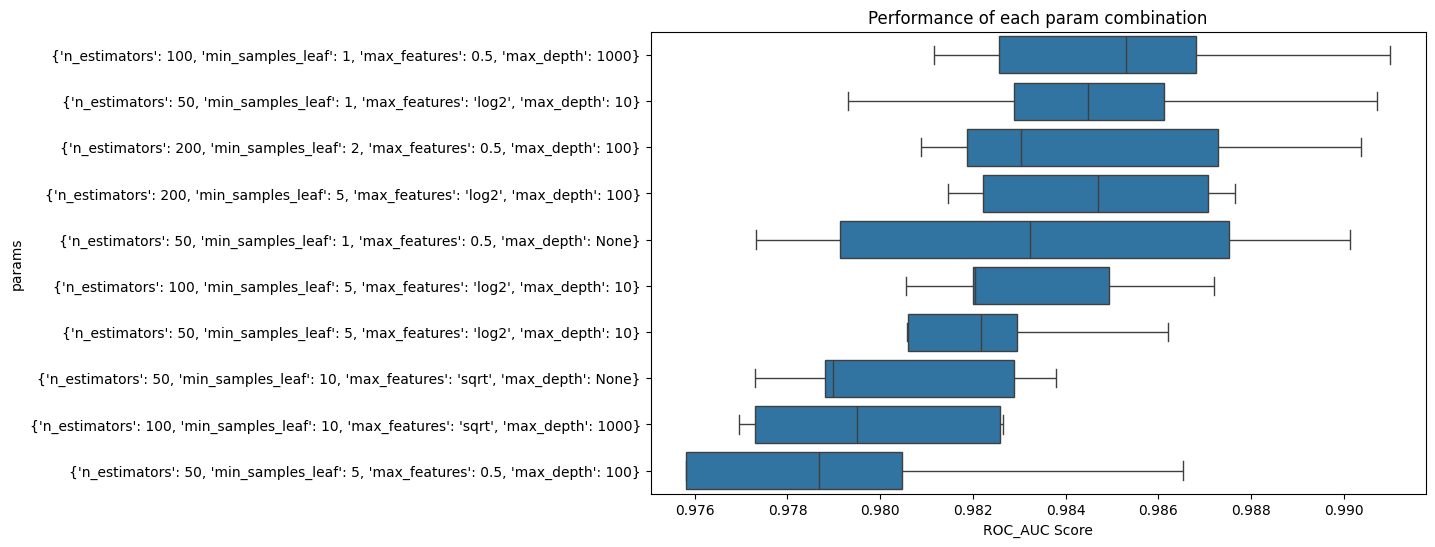

In [43]:
%matplotlib inline
plot_cv_results(rfc_search.cv_results_, "Performance of each param combination")

The competition between the combinations of parameters is really tight for `RandomForestClassifier`. On each randomized search we're getting new winners (which seems normal due to the **random** nature of the classifier).


In [44]:
rfc.set_params(**rfc_best_params)

evaluate_model(rfc, "random_forest_classifier")

### KNeighbors

Finally for the _simple_ models, we're moving on to `KNeighborsClassifier`.


In [45]:
from sklearn.neighbors import KNeighborsClassifier

param_distributions = {
    "n_neighbors": [10, 20, 30, 100],
    "weights": ["uniform", "distance"],
    "leaf_size": [30, 60, 90, 120],
}

knn = KNeighborsClassifier()
knn_search = randomized_search_cv(knn, param_distributions)
knn_best_params = knn_search.best_params_

> Note 1: The param distribution were adjusted based on the observations from running the randomized search several times.


> Note 2: The `algorithm` param isn't being fine tuned because by default it's set to "auto" depending on the dimentionality of the data it picks the right alrgorithm.


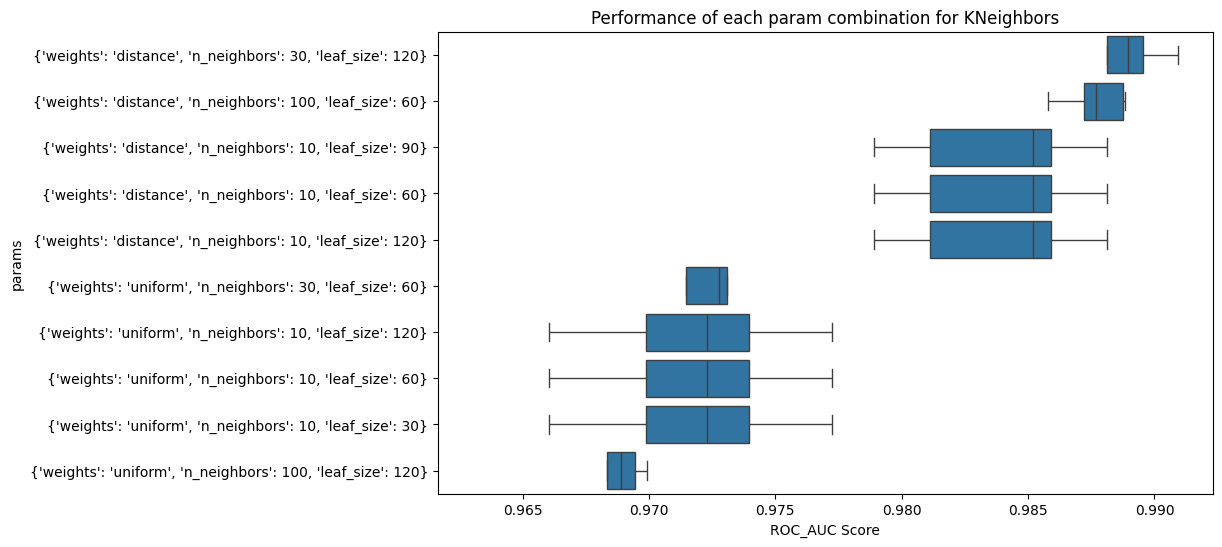

In [46]:
%matplotlib inline
plot_cv_results(knn_search.cv_results_, "Performance of each param combination for KNeighbors")

In [47]:
knn.set_params(**knn_best_params)
evaluate_model(knn, "knn")

Before we move on to the comparison, we will tune\* and and evaluate a dummy classifier for reference. The `DummyClassifier` will be handled just like the other models tested and evaluated. The testing phase will help us identify the best `strategy` parameter for our use case.


In [48]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()

param_distributions = {
    "strategy": ["most_frequent", "prior", "stratified", "uniform", "constant"],
    "constant": [0, 1],
}

dummy_search = randomized_search_cv(dummy, param_distributions)
dummy_best_params = dummy_search.best_params_

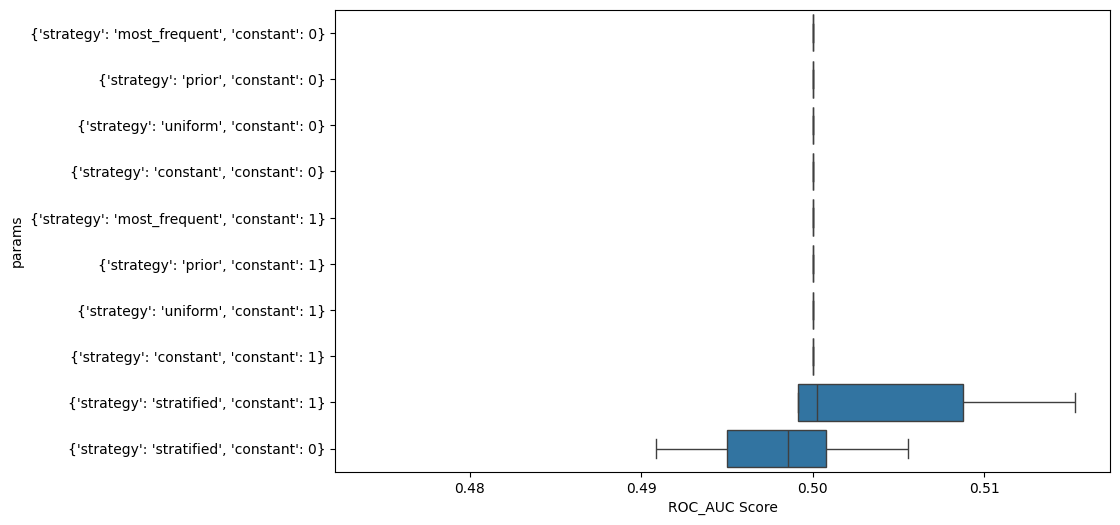

In [49]:
%matplotlib inline
plot_cv_results(dummy_search.cv_results_)

In [50]:
dummy.set_params(**dummy_best_params)
evaluate_model(dummy, "dummy")

Let's compare the scores of the different models to see how they performed in an array of metrics.


### Model Comparison

In the following code block, we will be writing a method that takes in the `model_scores` dict that has the following structure :

```py
model_scores = {
  model_name_1: {
    score_1: [float],
    score_2: [float]
  },
    model_name_2: {
    score_1: [float],
    score_2: [float]
  }
}
```

The method will average out the scores in each list and plot them for each model and each score type. Resulting in a bar plot where **each bar** represents **a score** for **a certain model**. The bars will be color coded _(one color per model)_.


In [51]:
from matplotlib import pyplot as plt

def generate_values_around_median(median, num_elements):
    # Calculate the half-size of the sequence
    half_size = num_elements // 2

    # Generate the sequence around the median
    sequence = np.arange(median - half_size, median + half_size + 1)

    return sequence


def plot_models_scores(model_scores):
    average_model_scores = {
        model: {metric: np.mean(scores) for metric, scores in metrics.items()}
        for model, metrics in model_scores.items()
    }

    metrics = list(next(iter(average_model_scores.values())).keys())

    # Get the number of models
    num_models = len(average_model_scores)
    num_metrics = len(metrics)

    # Generate a list of colors
    colors = plt.cm.tab10(np.linspace(0, 1, num_models))

    fig, ax = plt.subplots()
    index = np.arange(num_metrics) * num_models * 1.5

    for j, metric in enumerate(metrics):
        medians = generate_values_around_median(index[j], num_models)
        for i, (model, scores) in enumerate(average_model_scores.items()):
            ax.bar(medians[i], scores[metric], color=colors[i])
            ax.text(
                medians[i],
                scores[metric] + 0.01,
                f"{scores[metric]:.3f}",
                ha="center",
                va="bottom",
                rotation=-45,
            )

    ax.set_xticks(index)
    ax.set_xticklabels(metrics)
    plt.legend(list(average_model_scores.keys()), loc="lower center")
    plt.show()

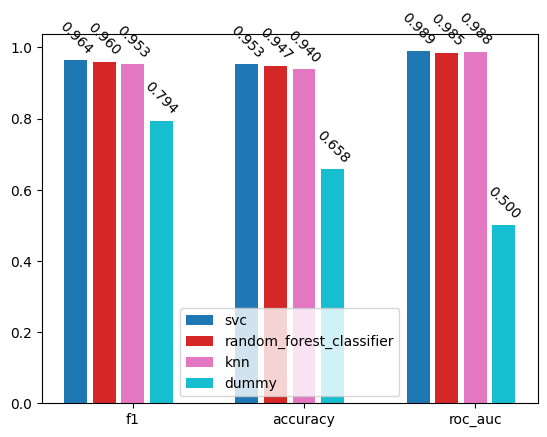

In [52]:
plot_models_scores(model_scores)

#### Results

We can conclude that the most performant model out of all the combinations tested is the `SVC` (Support Vector) with an `"rbf"` kernel for this **binary classification** task. It outperforms the other two models on all **metrics** with a smaller edge on `roc_auc`.


## Going Further

We were able to get some very good results from the _basic_ models offered by `scikit-lean`. However, nowadays we cannot ignore the power of **Neural Networks**. In a first step, we will be using the `NeuralNetPy` library for a simple network and then finally move on a **Convolutional Neural Network** with `keras`.


### NeuralNetPy

For the Neural Network with `NeuralNetPy` we will have a 3 layers network (1 Hidden layer) :

- Input layers with `n_neurons=len(x_train_pca[0])` (No need for further configuration since it's an input layer)
- Hidden layer with a number of neurons that will be chosen based off of performance
- Output layer with 2 neurons representing the two possible outcomes

To determine the optimal number of neurons for the hidden layers, we will train and evaluate networks with hidden layers containing **32**, **64**, and **128** neurons. If the network with the highest number of neurons (**128** in this case) performs the best, we will repeat the process with three new values, each incremented by **64** neurons, starting from the previous maximum. For example, we will test networks with **128**, **192**, and **256** neurons in the hidden layers. This will be done until the best value is not the highest value anymore.

The training data (**inputs** + **labels**) will then be passed to the `TrainingData2dI` object (`2dI` stands for 2 dimensional inputs) for batching.


In [53]:
from utils.NeuralNetPy import TrainingData2dI

train_data = TrainingData2dI(x_train_pca, y_train)
train_data.batch(128)

We are initializing the weights of the **hidden layer** with **HE** initialization. Since it has `RELU` as an activation function, `HE` is the standard for it. "Xavier initialization does
not work well with the RELU activation function, and instead propose an initialization of $v^2 = \frac{2}{N}$
(commonly referred to as the He initialization)."[[1]](#1)


`Adam` is being used as an optimizer because of it's learning rate adjusting capabilities. And `BCE` (Binary Cross-Entropy) for the loss function.


In the last step before training, the `ModelCheckpoint` will be passed as a callback, which will be used to detect and store the best model's parameters (using the `bestModelOnly` parameter).


In addition, we will pass the `CSVLogger` callback to store the **epoch** by **epoch** progression. It will give us insight on how the model performed throughout the training.


In [54]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from utils.NeuralNetPy import models, ACTIVATION, WEIGHT_INIT, LOSS, optimizers, layers, callbacks

def test_eval_nnp(num_neurons_h):
  network = models.Network()
  features_size = len(x_train_pca[0])
  network.addLayer(layers.Dense(features_size))
  network.addLayer(layers.Dense(num_neurons_h, ACTIVATION.SIGMOID, WEIGHT_INIT.GLOROT))
  network.addLayer(layers.Dense(2, ACTIVATION.SOFTMAX, WEIGHT_INIT.GLOROT))
  
  network.setup(optimizer=optimizers.Adam(0.01), loss=LOSS.BCE)
  
  network.train(train_data, 50, progBar=False)
  
  predictions = network.predict(x_test_pca)
  
  predictions = np.argmax(predictions, axis=1)
  
  roc_auc = roc_auc_score(y_test, predictions)
  accuracy = accuracy_score(y_test, predictions)
  f1 = f1_score(y_test, predictions)
  
  return {"f1": [f1], "accuracy": [accuracy], "roc_auc": [roc_auc]}

In [55]:
# dict to store the evaluation scores
nnp_model_scores = dict()

In [56]:
for num_neurons in [32, 64, 128]:
  scores = test_eval_nnp(num_neurons)
  nnp_model_scores[str(num_neurons)] = scores

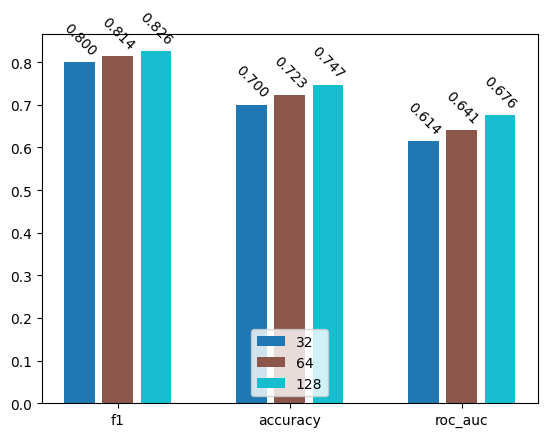

In [57]:
plot_models_scores(nnp_model_scores)

In [58]:
# generate a list with n values with x interval with a start_val (not included)
def gen_list_interval(n, interval=64, start_val=128):
  return [start_val + (i + 1) * interval for i in range(n)]

In [59]:
for num_neurons in gen_list_interval(2):
  scores = test_eval_nnp(num_neurons)
  nnp_model_scores[str(num_neurons)] = scores

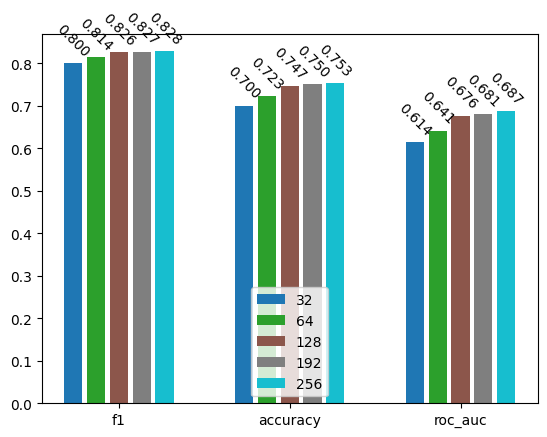

In [60]:
plot_models_scores(nnp_model_scores)

A slight increase is seen as the number of neurons increase in the hidden layer. That being said, we should keep on testing with higher values.

In [61]:
for num_neurons in gen_list_interval(2, start_val=254):
  scores = test_eval_nnp(num_neurons)
  nnp_model_scores[str(num_neurons)] = scores

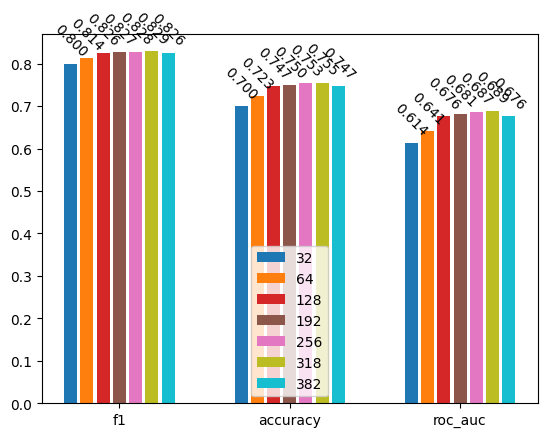

In [62]:
plot_models_scores(nnp_model_scores)


After **192** neurons it seems like the scores plateau (or verly slightly increase). However, even if it does so by a tiny amount the model with a hidden layer containing **318** seems to be outperforming the rest it deacreases at **382**. Therefore, that what we will use in the following steps. 

In [63]:
from utils.NeuralNetPy import models

network = models.Network() # simple network

In [64]:
from utils.NeuralNetPy import layers, ACTIVATION, WEIGHT_INIT

features_size = len(x_train_pca[0])

network.addLayer(layers.Dense(features_size))
network.addLayer(layers.Dense(318, ACTIVATION.SIGMOID, WEIGHT_INIT.GLOROT))
network.addLayer(layers.Dense(2, ACTIVATION.SOFTMAX, WEIGHT_INIT.GLOROT))

In [65]:
from utils.NeuralNetPy import optimizers, LOSS

network.setup(optimizer=optimizers.Adam(0.01), loss=LOSS.BCE)

In [66]:
from utils.NeuralNetPy import callbacks

network.train(train_data, 50, callbacks=[
  callbacks.CSVLogger('training.csv')
], progBar=False)

33.08252252455695

Using the logs collected in the `training.csv` file, we can plot the evolution of the **loss** and **accuracy** throughout the training process.


In [67]:
training_logs = pd.read_csv("training.csv")

training_logs.head()

,LOSS,ACCURACY,EPOCH,Unnamed: 3
0,1.614019,0.127451,0.0,NaN
1,1.279929,0.176471,1.0,NaN
2,1.161642,0.313725,2.0,NaN
3,1.083276,0.392157,3.0,NaN
4,1.019484,0.480392,4.0,NaN


We can drop the `Unnamed: 3` column and cast the epochs to `int`.


In [68]:
training_logs = training_logs.drop("Unnamed: 3", axis=1)
training_logs["EPOCH"] = training_logs["EPOCH"].astype("int32")

training_logs.head()

,LOSS,ACCURACY,EPOCH
0,1.614019,0.127451,0
1,1.279929,0.176471,1
2,1.161642,0.313725,2
3,1.083276,0.392157,3
4,1.019484,0.480392,4


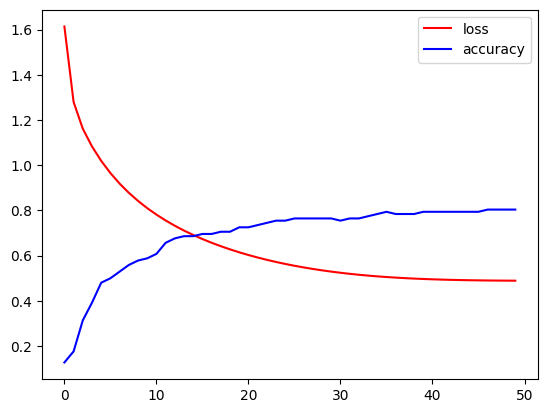

In [69]:
epochs = training_logs["EPOCH"].to_numpy()
loss = training_logs["LOSS"].to_numpy()
accuracy = training_logs["ACCURACY"].to_numpy()

fig, ax = plt.subplots()

ax.plot(epochs, loss, color="red", label="loss")
ax.plot(epochs, accuracy, color="blue", label="accuracy")

plt.legend()
plt.show()

We can see the convergence of the `loss` and `accuracy` towards `1` through the epochs.


In [70]:
predictions = network.predict(x_test_pca)

In [71]:
predictions = np.argmax(predictions, axis=1)

After converting the predictions, the `roc_auc`, `accuracy` and `f1` score will be calculated and stored in the `model_scores` dict.


In [72]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

roc_auc = roc_auc_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print("Accuracy: %.3f" % accuracy)
print("F1-score: %.3f" % f1)
print("roc auc: %.3f" % roc_auc)

network_scores = {"f1": [f1], "accuracy": [accuracy], "roc_auc": [roc_auc]}

model_scores['NeuralNetPy'] = network_scores

Accuracy: 0.755
F1-score: 0.829
roc auc: 0.689


### CNN with keras


For the **convolutional neural network** we will me using the cropped images instead of the reduced dimensions because the hole point of it is that it deals with a subset of each input at a time. for each neuron in the fully-connected layer, 10,000 weights would be required for processing an image sized 100 × 100 pixels[[2]](#2). Hence, the recovery of the train set with the images instead of the normalized numpy array. Thankfully, in the previous steps they were saved in their respective `.npy` files making their recovery much simpler.


In [73]:
x_train = np.load("./datasets/x_train.npy")
x_test = np.load("./datasets/x_test.npy")

In [74]:
print(x_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train.shape)

(4710, 50, 50)
(624, 50, 50)
(624,)
(4710,)


Before converting them to `numpy.array` the images were also converted to grayscale therefore only **1** our inputs only have **1** color channel.


In [75]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(50, 50, 1)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(2))

/Users/az-r-ow/epitech/msc/zoidberg/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [76]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       331,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 387,714 (1.48 MB)

 Trainable params: 387,714 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

Just like for the previous **neural network**, `adam` will be chosen as an optimizer and `BinaryCrossentropy` for the **loss**.


In [77]:
import tensorflow as tf

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.AUC(),
        tf.keras.metrics.F1Score(),
    ],
)

In [78]:
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train, num_classes=2)
y_test_encoded = to_categorical(y_test, num_classes=2)

history = model.fit(
    x_train, y_train_encoded, epochs=10, validation_data=(x_test, y_test_encoded)
)

Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - auc: 0.7998 - binary_accuracy: 0.7612 - f1_score: 0.7141 - loss: 2.0092 - val_auc: 0.8634 - val_binary_accuracy: 0.8245 - val_f1_score: 0.8250 - val_loss: 0.3684
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - auc: 0.9253 - binary_accuracy: 0.9020 - f1_score: 0.8941 - loss: 0.2361 - val_auc: 0.8287 - val_binary_accuracy: 0.8021 - val_f1_score: 0.7759 - val_loss: 0.4263
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - auc: 0.9476 - binary_accuracy: 0.9281 - f1_score: 0.9240 - loss: 0.1718 - val_auc: 0.8356 - val_binary_accuracy: 0.8189 - val_f1_score: 0.7840 - val_loss: 0.4580
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - auc: 0.9581 - binary_accuracy: 0.9454 - f1_score: 0.9402 - loss: 0.1389 - val_auc: 0.8360 - val_binary_accuracy: 0.8173 - val_f1_score: 0.7837 - val_loss: 0.4942
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - auc: 0.9703 - binary_accuracy: 0.9594 - f1_score: 0.9592 - loss: 0.1030 - val

In [79]:
val_dataset = load_dataset("Az-r-ow/chest_xray", split="validation")

# Converting to pandas will encode the images to bytestrings
val_dataset = format_dataset(val_dataset)
val_dataset.head()

,image,label,true_label
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,NORMAL


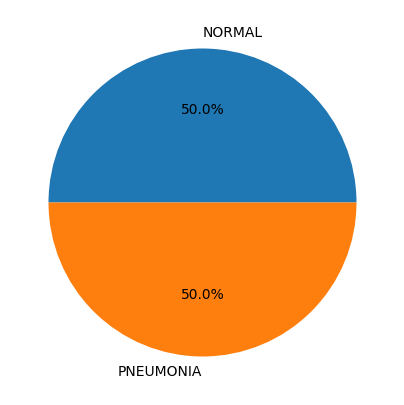

In [80]:
plot_value_counts(val_dataset, "true_label")

Apparently, it's a balanced validation set. Moving on to formatting and then validation.


In [81]:
x_validate = (
    val_dataset["image"]
    .map(lambda x: preprocess_image(x, (80, 80), (50, 50)))
    .reset_index(drop=True)
    .to_numpy()
)

x_validate = np.array([np.array(img) for img in x_validate])

y_validate = val_dataset["label"].reset_index(drop=True).to_numpy()
y_validate_encoded = to_categorical(y_validate, num_classes=2)

In [83]:
results = model.evaluate(x_validate, y_validate_encoded, return_dict=True)

cnn_scores = {
    "f1": [results["f1_score"]],
    "accuracy": [results["binary_accuracy"]],
    "roc_auc": [results["auc"]],
}

model_scores['cnn'] = cnn_scores

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - auc: 0.9219 - binary_accuracy: 0.8750 - f1_score: 0.8750 - loss: 0.2377


## Final Model Comparison

### Results

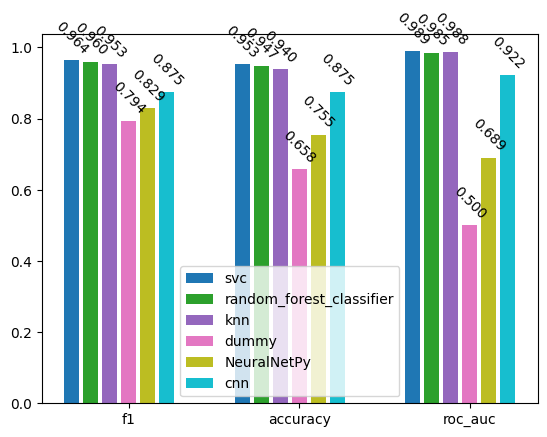

In [84]:
plot_models_scores(model_scores)

## Conclusion

The journey started with a dataset that took almost an hour to install (because of it's sheer size and a considerable latency on the host server) to data processing, `center_of_mass` analysis, PCA and ended with a comparison chart between different models from all sizes and complexities. From this chart, a clear pattern is formed, a pattern that says "sometimes simpler is better". 

## References

<a id="1">[1]</a>
Siddharth, K. K. (2017).
On weight initialization in deep neural networks.
arXiv:1704.08863 [cs.LG], 1.

<a id="2">[2]</a>
Convolutional neural network. (2024, May 16). In Wikipedia. https://en.wikipedia.org/wiki/Convolutional_neural_network
